## Exploring ACCRE data with Glenna Dunn, Chris Carlevato, & UrLeaka Newsome

In [269]:
import numpy as np
import pandas as pd
import seaborn as sns #; sns.set()
import matplotlib.pyplot as plt
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from datetime import time
import matplotlib.dates as mdates
%matplotlib notebook
%matplotlib inline
#plt.style.use('seaborn')
sns.set_palette("muted")I 
import warnings
warnings.filterwarnings('ignore')

In [270]:
filePath = 'data/july-2017-thru-june-2018.txt'

In [271]:
accre_data = pd.read_csv(filePath, delimiter='|')

## Q1: What is the relationship between queue time and (a) amount of memory requested, (b) amount of computing time requested? (Glenna)

### Restrict data to just jobs run from the production queue and jobs that were not cancelled

In [272]:
accre_data = accre_data.loc[(accre_data.Partition == 'production') & ~(accre_data.State.str.contains('CANCELLED'))]

In [273]:
accre_data.columns

Index(['JobID', 'JobIDRaw', 'Cluster', 'Partition', 'Account', 'Group', 'GID',
       'User', 'UID', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed',
       'ExitCode', 'State', 'NNodes', 'NCPUS', 'ReqCPUS', 'ReqMem', 'ReqGRES',
       'ReqTRES', 'Timelimit', 'NodeList', 'JobName'],
      dtype='object')

### Recast date/time columns as datetime format

In [274]:
accre_data.Submit = pd.to_datetime(accre_data.Submit)
accre_data.Start = pd.to_datetime(accre_data.Start)

### Calculate WaitTime and assign to new column

In [275]:
accre_data['WaitTime'] = accre_data.Start - accre_data.Submit

### Strip off the last two characters of ReqMem and pass to new columns

In [276]:
accre_data['NorC'] = accre_data.ReqMem.str[-1]
accre_data['MemUnits'] = accre_data.ReqMem.str[-2]
accre_data['ReqMemInBytes'] = accre_data.ReqMem.str[:-2]
accre_data['ReqMemInBytes'] = pd.to_numeric(accre_data.ReqMemInBytes, errors='ignore')
#accre_data.MemUnits.value_counts()

In [277]:
accre_data.NNodes = pd.to_numeric(accre_data.NNodes, errors = 'ignore')
accre_data.NCPUS = pd.to_numeric(accre_data.NCPUS, errors = 'ignore')

### Convert ReqMem to useable units (bytes)

In [278]:
mask = (accre_data.NorC == 'n')
accre_data.loc[mask,'ReqMemInBytes'] = accre_data.loc[mask,'ReqMemInBytes']*accre_data.loc[mask,'NNodes']
accre_data.loc[~mask,'ReqMemInBytes'] = accre_data.loc[~mask,'ReqMemInBytes']*accre_data.loc[~mask,'NCPUS']
maskG = (accre_data.MemUnits == 'G')
accre_data.loc[maskG,'ReqMemInBytes'] = accre_data.loc[maskG,'ReqMemInBytes']*(10.**9.)
maskM = (accre_data.MemUnits == 'M')
accre_data.loc[maskM,'ReqMemInBytes'] = accre_data.loc[maskM,'ReqMemInBytes']*(10.**6.)

### Reformat the Timelimit series

In [279]:
accre_data['ReqD'] = pd.to_numeric(accre_data.Timelimit.str[:-9]).fillna(value=0)*24. # in units of hours
accre_data['ReqHMS'] = pd.to_timedelta(accre_data.Timelimit.str[-7::]).astype('timedelta64[s]')/(3600.) # in units of hours

### Is there a relationship between the amount of computing time requested by a user and the queue time?

[]

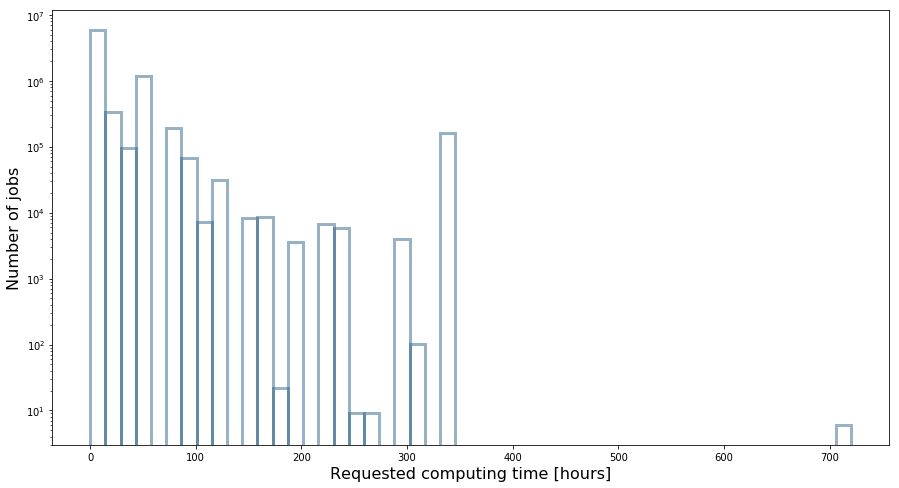

In [280]:
plt.figure(figsize=(15,8))
sns.distplot(accre_data.ReqD+accre_data.ReqHMS,kde=False,hist_kws={"histtype": "bar", "linewidth": 3,"alpha": 0.5, "edgecolor": "#31668a", "facecolor": "None"})
plt.xlabel('Requested computing time [hours]',fontsize=16)
plt.ylabel('Number of jobs',fontsize=16)
plt.semilogy()

### Let's drop the ACCRE admin jobs because they don't follow the same rules as everyone else!

In [281]:
accre_data.drop(accre_data[accre_data.Account == 'accre'].index,inplace=True)

[]

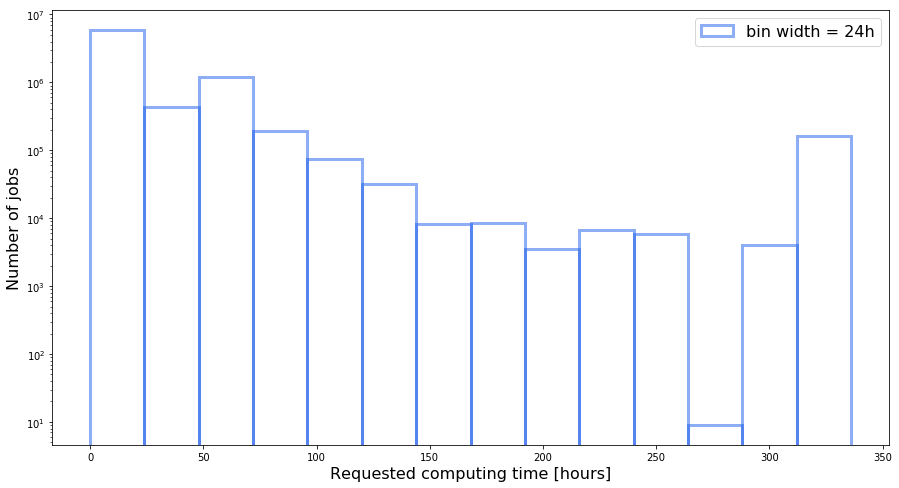

In [282]:
plt.figure(figsize=(15,8))
sns.distplot(accre_data.ReqD+accre_data.ReqHMS,kde=False,bins=int(350/24),hist_kws={"histtype": "bar", "linewidth": 3,"alpha": 0.5, "edgecolor": "#1d5dec", "facecolor": "None","label": "bin width = 24h"})
plt.xlabel('Requested computing time [hours]',fontsize=16)
plt.ylabel('Number of jobs',fontsize=16)
plt.legend(fontsize=16)
plt.semilogy()

Text(0,0.5,'Wait Time [Hours]')

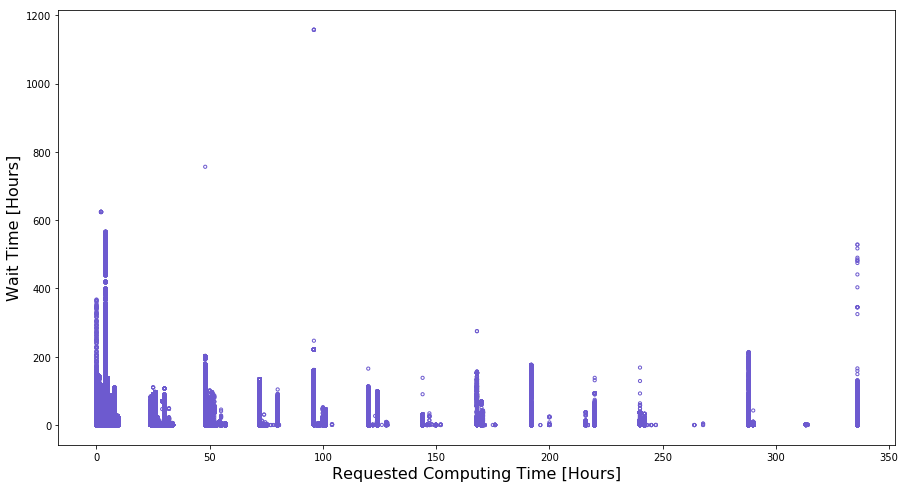

In [283]:
plt.figure(figsize=(15,8))
plt.scatter(accre_data.ReqD+accre_data.ReqHMS,accre_data.WaitTime.astype('timedelta64[s]')/3600.,s=10,edgecolor='#6d5acf',facecolor='None')
#plt.semilogx()
#plt.semilogy()
plt.xlabel('Requested Computing Time [Hours]',fontsize=16)
plt.ylabel('Wait Time [Hours]',fontsize=16)

### Let's look only at jobs that run for less than 24 hours.

Text(0,0.5,'Wait Time [Hours]')

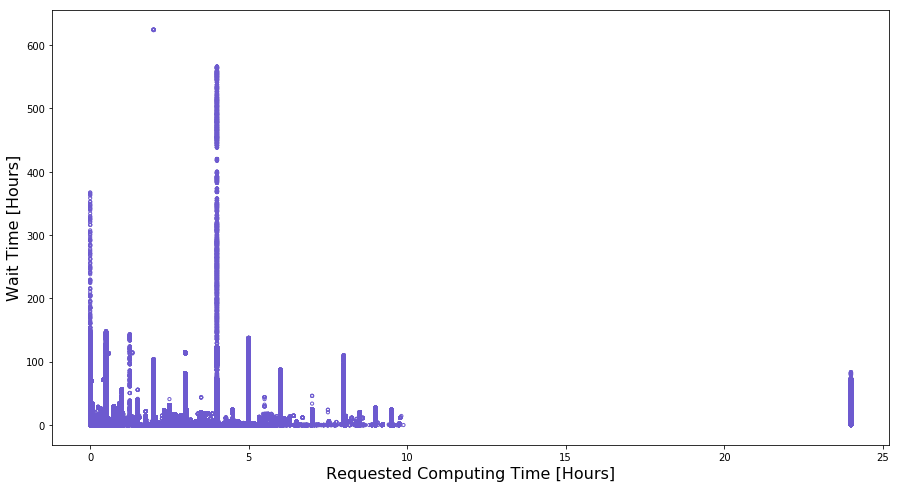

In [264]:
subset = accre_data.loc[accre_data.ReqD+accre_data.ReqHMS <= 24.]
plt.figure(figsize=(15,8))
plt.scatter(subset.ReqD+subset.ReqHMS,subset.WaitTime.astype('timedelta64[s]')/3600.,s=10,edgecolor='#6d5acf',facecolor='None')
#plt.semilogx()
#plt.semilogy()
plt.xlabel('Requested Computing Time [Hours]',fontsize=16)
plt.ylabel('Wait Time [Hours]',fontsize=16)

### Now let's consider a single group of users, N-Body, that have the same fairshare.

(11049, 31)


Text(0,0.5,'Wait Time [Hours]')

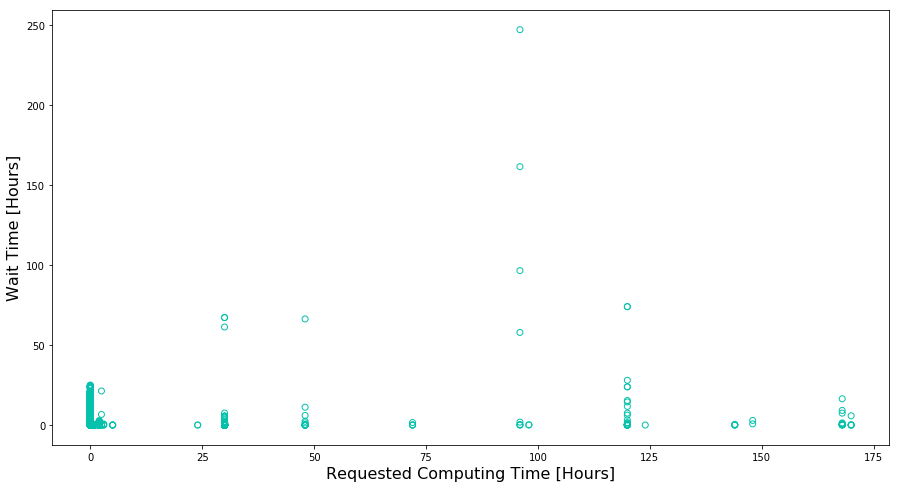

In [265]:
plt.figure(figsize=(15,8))
subset = accre_data.loc[accre_data.Group=='nbody']
print(subset.shape)
plt.scatter(subset.ReqD+subset.ReqHMS,subset.WaitTime.astype('timedelta64[s]')/3600.,edgecolor='#06c2ac',facecolor='None')
#plt.semilogy()
plt.xlabel('Requested Computing Time [Hours]',fontsize=16)
plt.ylabel('Wait Time [Hours]',fontsize=16)

### Some thoughts on requested computing time and total queue time:
* Jobs requesting less than about 24 hours or near the maximum wall time are associated with larger queue times
* Increased queue times are also associated with integer number of days
* These are popular requests, and so the increased queue time may be more directly tied to a large number of jobs with similar specs
* Users would be advised to ask for only the amount of time that they need to optimize queue times!

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Does a relationship exist between the amount of memory requested by a user and their wait time in the queue?

[]

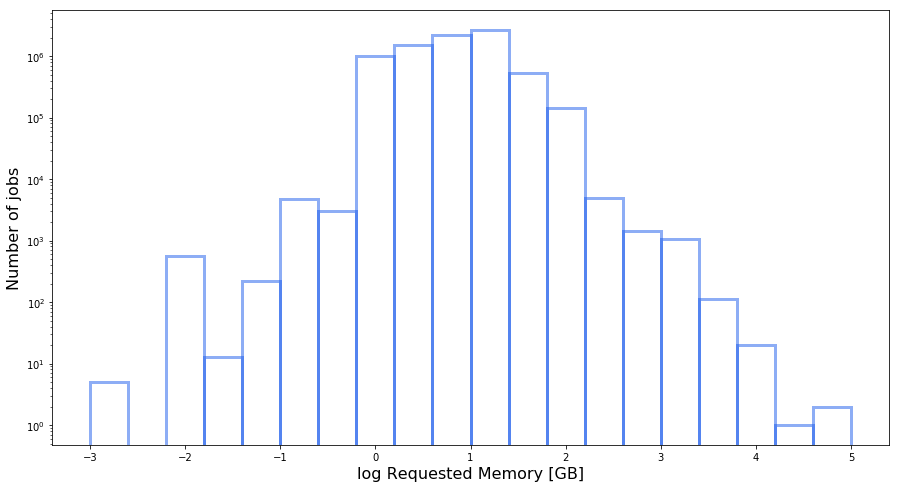

In [266]:
plt.figure(figsize=(15,8))
sns.distplot(np.log10(accre_data.ReqMemInBytes.dropna()/(10.**9)), kde=False, bins=20, hist_kws={"histtype": "bar", "linewidth": 3,"alpha": 0.5, "edgecolor": "#1d5dec", "facecolor": "None"})
plt.xlabel('log Requested Memory [GB]',fontsize=16)
plt.ylabel('Number of jobs',fontsize=16)
plt.semilogy()

Text(0,0.5,'Wait Time [Hour]')

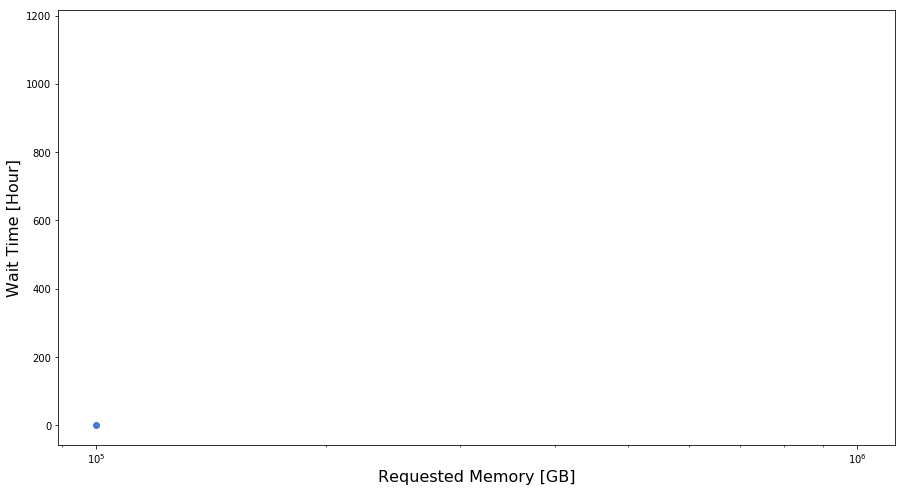

In [284]:
plt.figure(figsize=(15,8))
plt.scatter(accre_data.ReqMemInBytes/(10.**9.),accre_data.WaitTime.astype('timedelta64[s]')/3600.)
plt.semilogx()
plt.xlabel('Requested Memory [GB]',fontsize=16)
plt.ylabel('Wait Time [Hour]',fontsize=16)

### Let's look at a single group, N-Body, which all have the same fair-share rank.

1.024000e+09    9833
2.000000e+09     855
8.000000e+09     207
1.000000e+09      57
2.000000e+11      22
5.000000e+08      13
6.400000e+10       7
5.000000e+10       5
1.600000e+10       5
1.280000e+11       5
5.700000e+11       4
8.740000e+11       4
3.800000e+11       4
4.560000e+11       3
6.080000e+11       3
6.000000e+09       3
7.600000e+11       2
1.026000e+12       2
8.000000e+10       2
1.102000e+12       1
9.500000e+11       1
5.320000e+11       1
7.980000e+11       1
1.140000e+12       1
1.440000e+11       1
1.920000e+11       1
1.331200e+10       1
6.460000e+11       1
4.180000e+11       1
6.840000e+11       1
3.040000e+11       1
7.220000e+11       1
Name: ReqMemInBytes, dtype: int64

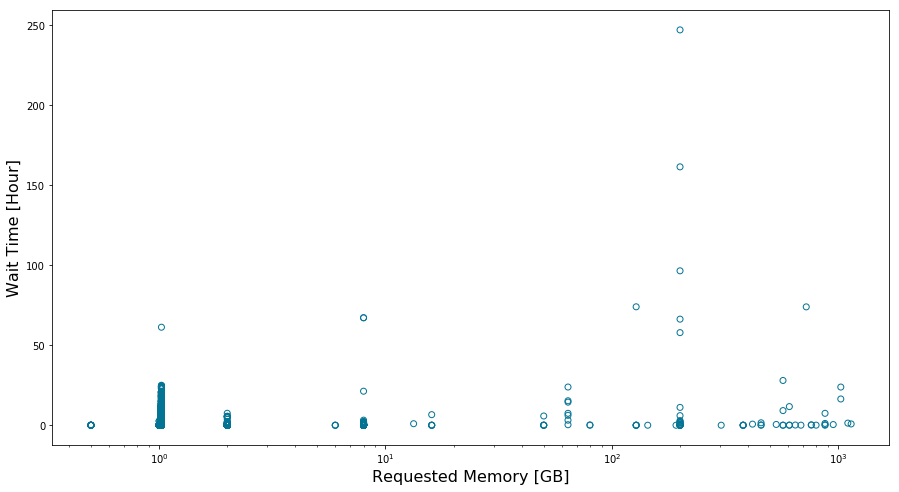

In [182]:
plt.figure(figsize=(15,8))
subset = accre_data.loc[accre_data.Group=='nbody']
plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.,edgecolor='#047495',facecolor='None')
plt.semilogx()
plt.xlabel('Requested Memory [GB]',fontsize=16)
plt.ylabel('Wait Time [Hour]',fontsize=16)
subset.ReqMemInBytes.value_counts()

Text(0,0.5,'Wait Time [Hour]')

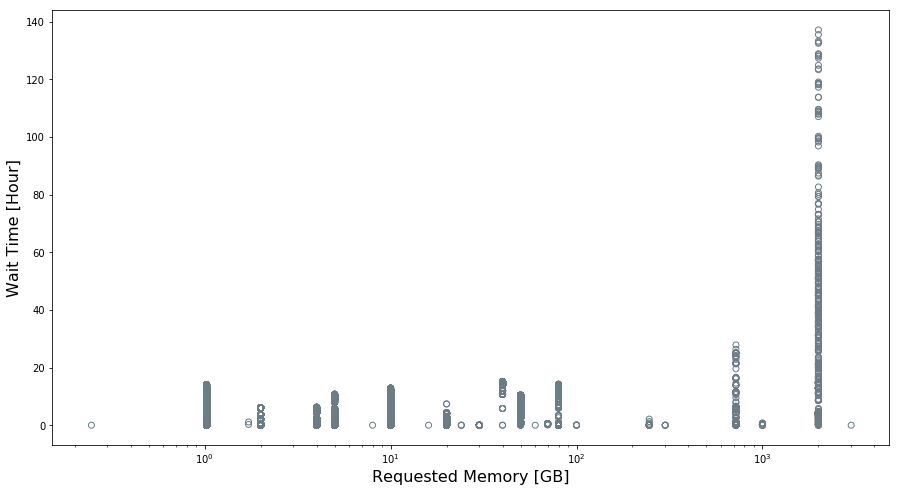

In [172]:
plt.figure(figsize=(15,8))
plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.,edgecolor='#6b7c85',facecolor='None')
plt.semilogx()
plt.xlabel('Requested Memory [GB]',fontsize=16)
plt.ylabel('Wait Time [Hour]',fontsize=16)

In [190]:
subset = subset.loc[subset.ReqMemInBytes == 2*10**11]
subset[['UID','Submit','WaitTime','ReqMem','Timelimit','NCPUS','Elapsed','State']]

,UID,Submit,WaitTime,ReqMem,Timelimit,NCPUS,Elapsed,State
55331,103978.0,2017-07-05 22:13:06,0 days 00:02:30,1000Mc,4-00:00:00,200,23:21:13,NODE_FAIL
169783,103978.0,2017-07-10 16:23:26,4 days 00:28:04,1000Mc,4-00:00:00,200,4-00:01:41,TIMEOUT
1284252,103978.0,2017-08-09 18:48:26,0 days 00:00:01,1000Mc,4-00:00:00,200,4-00:00:16,TIMEOUT
1610252,103978.0,2017-08-16 21:17:43,2 days 09:51:11,1000Mc,4-00:00:00,200,4-00:00:13,TIMEOUT
1924691,103978.0,2017-08-29 20:21:58,6 days 17:24:50,1000Mc,4-00:00:00,200,00:02:14,FAILED
2031094,103978.0,2017-09-05 14:38:55,10 days 06:58:51,1000Mc,4-00:00:00,200,4-00:00:07,TIMEOUT
3145966,103978.0,2017-09-25 16:39:24,2 days 18:16:31,1000Mc,2-00:00:00,200,2-00:00:14,TIMEOUT
3583050,103978.0,2017-10-02 15:49:45,0 days 02:20:45,1000Mc,2-00:00:00,200,2-00:00:38,TIMEOUT
3692972,103978.0,2017-10-04 18:19:17,0 days 11:08:11,1000Mc,2-00:00:00,200,06:11:27,FAILED
3727007,103978.0,2017-10-05 13:40:07,0 days 05:58:49,1000Mc,2-00:00:00,200,00:07:42,FAILED


In [238]:
badDay = (accre_data.Submit >= '2017-07-10 15:23:26') & (accre_data.Submit <= '2017-07-10 16:23:26')
subset = accre_data.loc[(badDay)]
subset.shape

(844, 31)

In [239]:
subset = accre_data.loc[(badDay) & (accre_data.Group=='nbody')]
subset.shape

(3, 31)

In [240]:
subset[['UID','Submit','WaitTime','ReqMem','Timelimit','NCPUS','Elapsed','State']]

,UID,Submit,WaitTime,ReqMem,Timelimit,NCPUS,Elapsed,State
169076,NaN,2017-07-10 15:37:20,0 days 00:00:01,1000Mc,5-00:00:00,128,4-06:34:22,COMPLETED
169684,103978.0,2017-07-10 16:13:46,0 days 00:00:19,38000Mn,5-00:00:00,120,4-23:43:02,COMPLETED
169783,103978.0,2017-07-10 16:23:26,4 days 00:28:04,1000Mc,4-00:00:00,200,4-00:01:41,TIMEOUT


In [241]:
badDay = (accre_data.Submit >= '2017-09-05 13:38:55') & (accre_data.Submit <= '2017-09-05 14:38:55')
subset = accre_data.loc[(badDay)]
subset.shape

(502, 31)

In [242]:
subset = accre_data.loc[(badDay) & (accre_data.Group=='nbody')]
subset.shape

(2, 31)

In [243]:
subset[['UID','Submit','WaitTime','ReqMem','Timelimit','NCPUS','Elapsed','State']]

,UID,Submit,WaitTime,ReqMem,Timelimit,NCPUS,Elapsed,State
2031025,103978.0,2017-09-05 14:33:34,0 days 11:38:29,38000Mn,5-00:00:00,120,4-23:33:14,COMPLETED
2031094,103978.0,2017-09-05 14:38:55,10 days 06:58:51,1000Mc,4-00:00:00,200,4-00:00:07,TIMEOUT


In [227]:
goodDay = (accre_data.Submit >= '2017-07-05 21:13:06') & (accre_data.Submit <= '2017-07-05 22:13:06')
subset = accre_data.loc[goodDay]
subset.shape

(2350, 31)

In [228]:
subset = accre_data.loc[goodDay & (accre_data.Group=='nbody')]
subset.shape

(1, 31)

### Some thoughts on requested memory and queue time:
* More popular, integer values of requested memory may lead to longer queue times
* If you are a user who submits multiple jobs in a short window of time, later jobs may experience longer queue times

### Possible future work: 
Is there any relationship between the time of day of submission and queue time?  Is it worthwhile to submit your jobs at 3 AM to avoid long wait times?

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Q2: Identify problem nodes that have an above-average fail rate. (Chris)

In [12]:
accre_data = pd.read_csv(filePath, delimiter='|')

/Users/gcdunn/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Before we answer that question, we will only consider jobs that used 1 node (which is about 91% of all jobs).

In [13]:
accre_data['NNodes'].value_counts()

1      12370952
0        108668
2          9344
3          2746
4          2357
5           811
100         741
6           497
8           488
36          273
50          237
7           202
10          157
82          144
16          131
25          122
64          112
12          102
32           82
9            73
20           62
13           61
11           60
15           56
14           52
17           45
19           45
18           42
30           37
128          32
         ...   
96            2
61            2
76            2
98            2
83            2
77            1
89            1
188           1
136           1
132           1
131           1
125           1
124           1
118           1
117           1
116           1
115           1
114           1
111           1
109           1
84            1
85            1
104           1
86            1
97            1
200           1
95            1
88            1
93            1
94            1
Name: NNodes, Length: 12

In [14]:
One_Node= accre_data[accre_data['NNodes'] == 1]

### Let's look at the failure rate of the most used node--vmp1409--before we look at all nodes.

In [15]:
accre_data[(accre_data['State'] == "NODE_FAIL") & (accre_data["NodeList"] == "vmp1409")]

,JobID,JobIDRaw,Cluster,Partition,Account,Group,GID,User,UID,Submit,...,State,NNodes,NCPUS,ReqCPUS,ReqMem,ReqGRES,ReqTRES,Timelimit,NodeList,JobName
4586468,20415282,20415282,accre,production,root,root,0,root,0.0,2017-10-28T14:20:08,...,NODE_FAIL,1,16,1,5Gn,NaN,"cpu=1,mem=5G,node=1",01:30:00,vmp1409,gpfs-upgrade.slurm


In [16]:
print(len(accre_data[accre_data["NodeList"]=="vmp1409"]))

92419


In [17]:
len(accre_data[(accre_data['State'] == "NODE_FAIL") & (accre_data["NodeList"] == "vmp1409")])

1

In [18]:
len(accre_data[(accre_data['State'] == "NODE_FAIL") & (accre_data["NodeList"] == "vmp1409")])/len(accre_data[accre_data["NodeList"]=="vmp1409"])

1.0820285871952737e-05

### Node vmp1409 was used to execute 92,419 jobs. It had 1 node failure. The frequency of failure was basically 0% (YAY!).

### Let's create a separate dataframe that calculates node failure for each node.

In [19]:
bad_nodes = accre_data.loc[(accre_data['State']=='NODE_FAIL') & (accre_data['NNodes']==1)]

In [20]:
node_df= pd.DataFrame(accre_data.NodeList.value_counts(ascending=False)).reset_index()
node_df = node_df.rename(index = str, columns = {'index': 'Node Code', 'NodeList': 'Total Jobs'})

In [21]:
node_failure_df = pd.DataFrame(bad_nodes.NodeList.value_counts(ascending=False)).reset_index()
node_failure_df = node_failure_df.rename(index = str, columns = {'index' : 'Node Code', 'NodeList': 'Failed Jobs'})

In [22]:
combined_df = pd.merge(node_df, node_failure_df, on ="Node Code", how = "inner")

In [23]:
combined_df['Frequency'] = combined_df['Failed Jobs']/combined_df['Total Jobs']

In [24]:
combined_df.sort_values(by=['Frequency'], ascending=False)

,Node Code,Total Jobs,Failed Jobs,Frequency
592,vm-qa-node004,6,1,0.166667
588,vmp595,1018,8,0.007859
586,vmp598,1042,7,0.006718
584,vmp592,1084,7,0.006458
579,vmp692,1117,7,0.006267
578,vmp696,1118,7,0.006261
590,gpu0022,505,3,0.005941
582,gpu0010,1097,5,0.004558
581,vmp695,1097,5,0.004558
580,vmp597,1099,5,0.004550


### Forunately, the most commonly used node (vmp 1409) had the lowest failure rate.

In [25]:
combined_df['Frequency'].mean()

0.0007285941178738537

### The mean node failure rate is about .07%.

In [26]:
combined_df['Frequency'].median()

0.0002610966057441253

### The median failure rate is about 0.03%.

In [27]:
combined_df["Frequency"].std()

0.0068755232336971

### One standard deviation is about 0.7%.

### Let's look at the distribution of failure rates with a histogram.

Text(0,0.5,'Frequency of Failure')

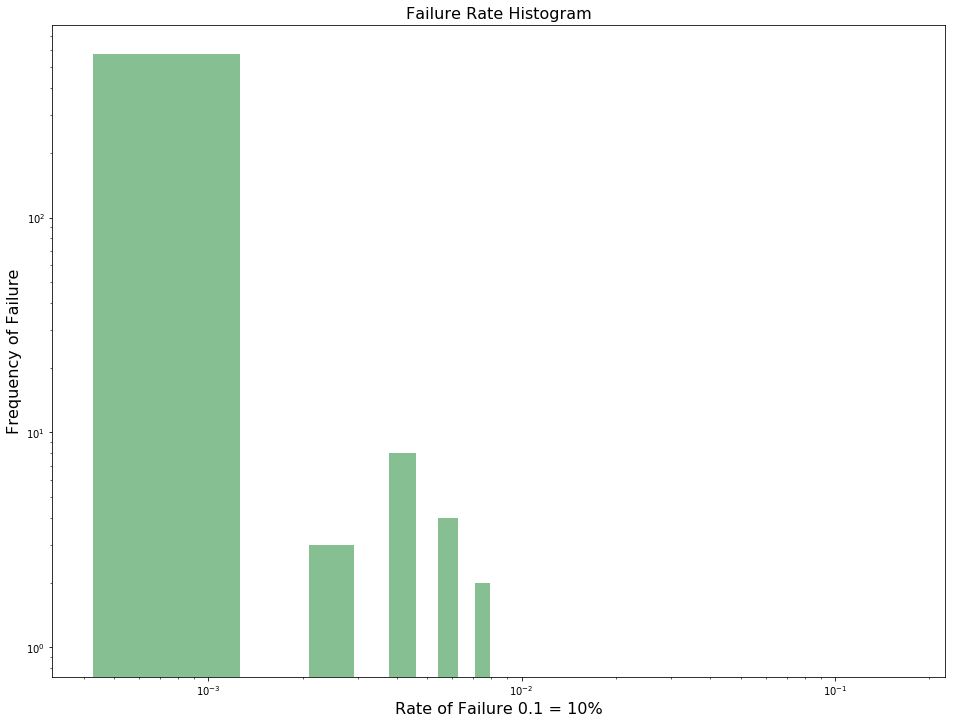

In [28]:
combined_df.hist(column='Frequency', bins=100, grid=False, figsize=(16,12), color='#86bf91', zorder=2, rwidth=0.5,)
plt.xlabel("Rate of Failure 0.1 = 10%", fontsize=16)
plt.semilogx()
plt.semilogy()
plt.title("Failure Rate Histogram",fontsize=16)
plt.ylabel("Frequency of Failure",fontsize=16)

Text(0.5,0,'Frequency of Failure')

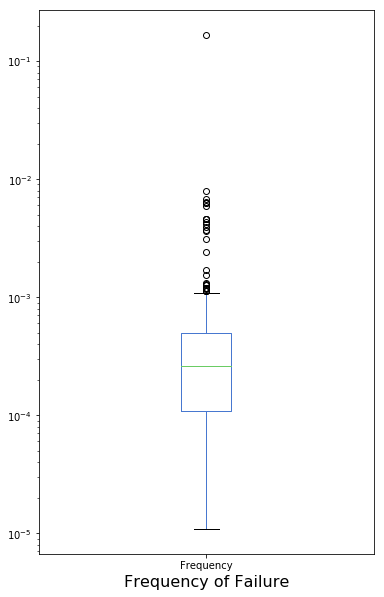

In [29]:
combined_df["Frequency"].plot(kind='box', figsize=(6,10))
plt.semilogy()
plt.xlabel("Frequency of Failure",fontsize=16)

### The boxplot and histogram shows the data is skewed right b/c of some high frequency node failure outliers. Let's figure out exactly which nodes have these high failure rates, and determine how they compare to the median.

In [30]:
q = [0.25, 0.75]
combined_df["Frequency"].quantile(q)

0.25    0.000108
0.75    0.000499
Name: Frequency, dtype: float64

### Depending on how we define an "outlier," any node with a failure rate above the 75% percentile (0.05% fail rate) we may consider to have a disproportionately high fail rate.

In [31]:
combined_df.nlargest(5, "Frequency")

,Node Code,Total Jobs,Failed Jobs,Frequency
592,vm-qa-node004,6,1,0.166667
588,vmp595,1018,8,0.007859
586,vmp598,1042,7,0.006718
584,vmp592,1084,7,0.006458
579,vmp692,1117,7,0.006267


### Node vm-qa-node004 has the highest failure rate, about 17%. This is more than 24 standard deviations from the mean. We can safely say that this a "bad node" because it is such an extreme outlier. It should be pointed out that it was only used for 6 total jobs--so this high fail rate may not necessarily be relevant.

### The next highest frequency of failures were as follows: Node vmp595 has a 0.79% failure rate, node vmp598 has a 0.67% failure rate, node vmp592 has a 0.65% failure rate, and node vmp692 has a 0.62% failure rate. We can safely consider the top 5 node failure rates outliers because they well outside the inner-quartile range--which has about an 0.05% failure rate cut at the 75th percentile.

### Let's focus in on the top quartile (149 nodes) to see if the distribution of failure rates looks different from the general dataset.

In [32]:
subset_filter = combined_df.loc[combined_df['Frequency']>= combined_df["Frequency"].quantile(0.75)]

In [33]:
subset_filter.nlargest(5, "Frequency")

,Node Code,Total Jobs,Failed Jobs,Frequency
592,vm-qa-node004,6,1,0.166667
588,vmp595,1018,8,0.007859
586,vmp598,1042,7,0.006718
584,vmp592,1084,7,0.006458
579,vmp692,1117,7,0.006267


Text(0.5,0,'Top Quartile Failure Relative Comparison')

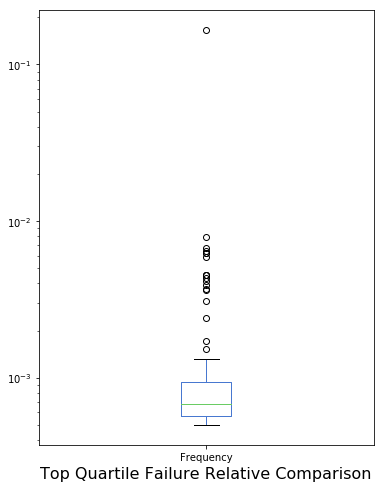

In [34]:
subset_filter["Frequency"].plot(kind='box',figsize=(6,8))
plt.semilogy()
plt.xlabel('Top Quartile Failure Relative Comparison', fontsize=16)

Text(0.5,1,'Frequency of Failure Histogram for the Top Quartile')

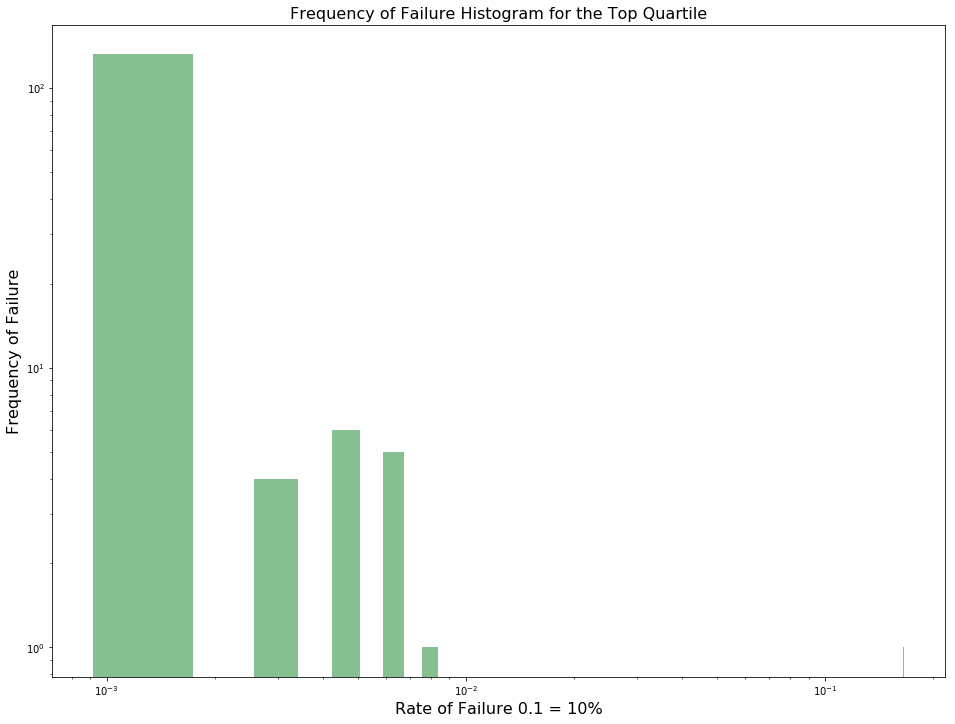

In [35]:
subset_filter.hist(column='Frequency', bins=100, grid=False, figsize=(16,12), color='#86bf91', zorder=2, rwidth=0.5)
plt.xlabel("Rate of Failure 0.1 = 10%", fontsize=16)
plt.semilogx()
plt.semilogy()
plt.ylabel("Frequency of Failure", fontsize=16)
plt.title("Frequency of Failure Histogram for the Top Quartile", fontsize=16)

Text(0,0.5,'Top Quartile Failed Jobs')

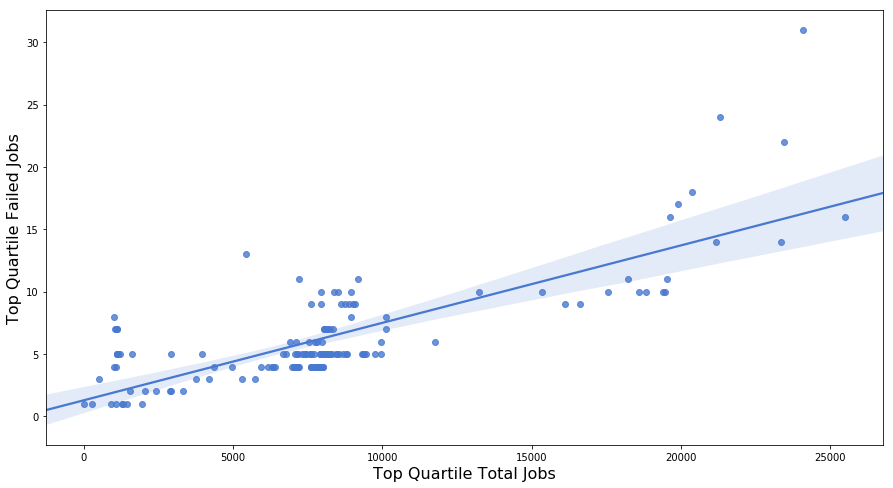

In [36]:
plt.figure(figsize=(15,8))
ax = sns.regplot(x= "Total Jobs", y = "Failed Jobs", data=subset_filter)
plt.xlabel('Top Quartile Total Jobs', fontsize=16)
plt.ylabel('Top Quartile Failed Jobs', fontsize=16)

In [37]:
subset_filter['Frequency'].median()

0.0006782419967444384

### This boxplot and the historgram tell us that most data in the top quartile has a failure rate of around 0.07% (less than a tenth of a percent). This explains why the histogram is unimodal. AKA the spread is relatively tight, even among the top quartile. There are handful of nodes outside of the 75th percentile within the top quartile that buck this trend (aks above the 94th percentile). Thus, we will safely consider any node above the 94th percentile a "bad node," as opposed to all nodes in the top quartile.

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Q3: Identify problem users who submit more than 500 jobs that run for less than 5 minutes in a four hour window.  (UrLeaka)

In [38]:
accre_data = pd.read_csv(filePath, delimiter='|',dtype='str')

### Start and end times were analyzed and converted to datetime64 format in order to eventually determine and compare "elapsed time". 

In [39]:
accre_data.Start = pd.to_datetime(accre_data.Start)
accre_data.End = pd.to_datetime(accre_data.End)

In [40]:
accre_data['RunCalc'] = accre_data.End - accre_data.Start

### Now we convert 'RunCalc' to number of days in order to filter out all elapsed times greater than 24 hours.

In [41]:
days=accre_data.RunCalc.dt.days

### Here we filtered all cases that have not completed and cases that took more than 24 hrs.

In [42]:
completed=accre_data[accre_data.State == 'COMPLETED']
completed['days']=days
less24hrs = completed[completed.days< 1]

/Users/gcdunn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Converted times to secs in order to filter out "RunCalc" or "Elapsed" times that took more than 5 min.  

In [43]:
secs_RunCalc=less24hrs.RunCalc.dt.seconds
less24hrs['secs_RunCalc'] = secs_RunCalc

/Users/gcdunn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
prob_jobs = less24hrs[less24hrs.secs_RunCalc<=300]

### Reduced dataframes to necessary columns

In [45]:
prob_jobs2=prob_jobs[['JobIDRaw', 'User', 'Submit','RunCalc', 'secs_RunCalc']]
prob_jobs2.head()

,JobIDRaw,User,Submit,RunCalc,secs_RunCalc
4,15811617,uscms010,2017-07-01T05:00:00,00:00:10,10
5,15811618,autocms,2017-07-01T05:00:01,00:03:18,198
6,15811619,tuos,2017-07-01T05:00:02,00:02:03,123
7,15811621,uscms010,2017-07-01T05:00:22,00:00:10,10
8,15811624,autocms,2017-07-01T05:01:01,00:04:47,287


In [46]:
prob_users=prob_jobs2.User.value_counts()

### Now we will find users with more than 500 jobs

In [47]:
pu1=prob_users>500

### Convert the series to a dictionary where each user is associated with a boolean.

In [48]:
pu2=pu1.to_dict()

In [49]:
badusers=[k for k,v in pu2.items() if v == True]

### Compared new list to exisiting dataframe and selected appropiate users that have more than 500 jobs under 5 min.

In [50]:
prob_user_jobs=prob_jobs2.loc[prob_jobs2.User.isin(badusers)]

In [51]:
prob_user_jobs.loc[:,'Submit'] = pd.to_datetime(prob_user_jobs.Submit)

/Users/gcdunn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [52]:
pu3=prob_user_jobs.sort_values(['Submit'])

### Create syntax to order/group jobs by users and the jobs they produced every 4 hours

In [53]:
rollingjobs=pu3.groupby('User').rolling('14400s', on='Submit').JobIDRaw.count()

### JobIDRaw now represents the number of jobs submitted within 4 hour period and counts jobs by user within 4 hours

In [54]:
rolling_df=pd.DataFrame(rollingjobs).reset_index()
rolling_df.head()

,User,Submit,JobIDRaw
0,abraha1,2017-10-07 19:12:39,1.0
1,abraha1,2017-10-07 19:21:18,2.0
2,abraha1,2017-10-07 19:29:20,3.0
3,abraha1,2017-10-07 19:32:12,4.0
4,abraha1,2017-10-07 21:28:42,5.0


### Evaluate max count per user.  JobIDRaw column now represents the max count for jobs that occur within a 4 hour period and the users that ran them.

In [55]:
rolling_df_max=rolling_df.groupby('User').max().reset_index()
rolling_df_max.head()

,User,Submit,JobIDRaw
0,abraha1,2018-06-28 20:17:04,6234.0
1,autocms,2018-06-30 23:55:01,299.0
2,badamifs,2017-08-14 13:50:52,1576.0
3,baoj,2018-01-18 01:05:07,127.0
4,boydb1,2018-06-30 10:46:17,97.0


In [56]:
# Find the users who ran more than 500 jobs within a 4 hour window
rolling_user_max=rolling_df_max.loc[rolling_df_max['JobIDRaw']>=500]
rolling_user_max

,User,Submit,JobIDRaw
0,abraha1,2018-06-28 20:17:04,6234.0
2,badamifs,2017-08-14 13:50:52,1576.0
5,brancha1,2018-01-12 02:20:35,1192.0
7,brockc,2018-03-01 00:29:05,8206.0
8,brownbp1,2018-06-26 20:23:07,6833.0
9,cakira,2018-06-25 20:16:52,6388.0
15,chenr6,2018-06-27 22:00:48,1932.0
16,chipmajj,2018-05-07 15:15:23,10596.0
17,cmsglidein,2018-05-23 08:01:27,1390.0
18,dagostle,2017-11-15 17:41:01,1130.0


In [57]:
rolling_df_max.shape

(89, 3)

### Out of the 89 users who fit previous conditions (i.e. users with more than 500 jobs in total data set that were less than 5 min), 61 users have submitted more than 500 jobs within 4 hours

In [58]:
rolling_user_max.shape

(61, 3)

### Now we will count the users that reach 500 during a 4 hour time frame.  Note repeat offenders and index value to observe different job

In [59]:
users500up=rolling_df.loc[rolling_df['JobIDRaw'] == 500]
users500up

,User,Submit,JobIDRaw
969,abraha1,2018-01-27 23:34:02,500.0
3122,abraha1,2018-03-25 15:15:21,500.0
4573,abraha1,2018-06-22 06:05:40,500.0
5649,abraha1,2018-06-22 20:20:02,500.0
6458,abraha1,2018-06-24 00:07:11,500.0
9158,abraha1,2018-06-27 17:51:37,500.0
432305,badamifs,2017-08-09 22:40:21,500.0
432894,badamifs,2017-08-11 15:07:06,500.0
434577,badamifs,2017-08-14 13:45:07,500.0
439283,brancha1,2017-10-18 03:23:27,500.0


### You can see here that several names appear more than once.  Now we will determine the users with repeat offenses.

In [60]:
r_o = users500up.User.value_counts()
repeated_offender = pd.DataFrame(r_o).reset_index()
repeated_offender1=repeated_offender.rename(index=str,columns={'User':'Offense_Count', 'index':'User'})
repeated_offender1.head()

,User,Offense_Count
0,brockc,115
1,msrc,82
2,moonj,50
3,ozgunka,47
4,jiany17,21


### Now we will look at users with more than 10 offenses 

In [61]:
repeated_offender2=repeated_offender1.loc[repeated_offender1['Offense_Count']>=10]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

<Figure size 1080x576 with 0 Axes>

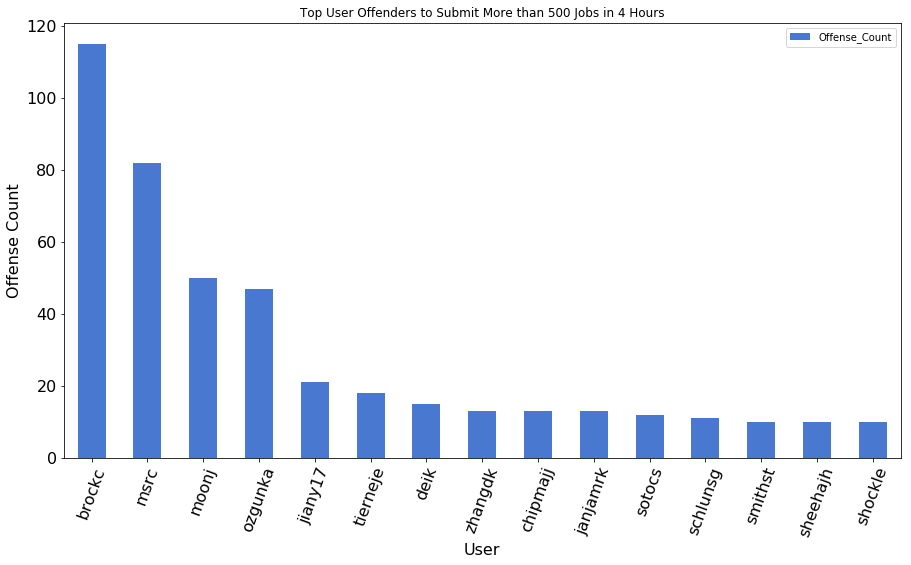

In [62]:
plt.figure(figsize=(15,8))
repeated_offender2.plot(kind='bar',x='User',title='Top User Offenders to Submit More than 500 Jobs in 4 Hours',figsize=(15,8),fontsize=16)
plt.xlabel('User', fontsize=16)
plt.ylabel('Offense Count', fontsize=16)
plt.xticks(rotation=70)

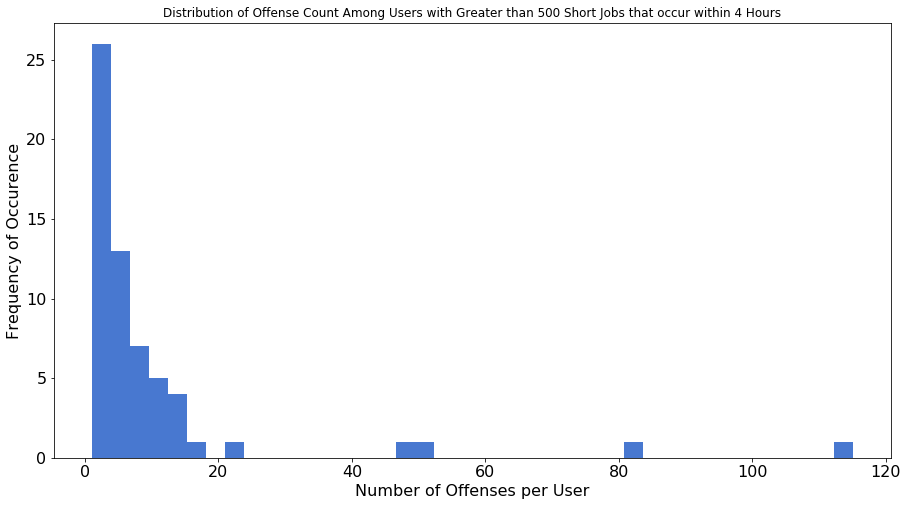

In [63]:
plt.figure(figsize=(15,8))
repeated_offender1['Offense_Count'].plot.hist(bins=40,title='Distribution of Offense Count Among Users with Greater than 500 Short Jobs that occur within 4 Hours',fontsize=16)
plt.xlabel('Number of Offenses per User',fontsize=16)
plt.ylabel('Frequency of Occurence', fontsize=16)
plt.show()